In [1]:
import project_path
from model.neural_model import NeuralModel
import connectomes
import distance
import dynamics

import matplotlib.pyplot as plt
import numpy as np
import pdb

N = 3
simul_ts = 1000
eval_ts = 500
dt = 0.01
simul_timepoints = np.arange(0, simul_ts * dt, dt)
eval_timepoints = np.arange((simul_ts - eval_ts)*dt, simul_ts * dt, dt)

# Golden dynamics

Total runtime = 0.10s


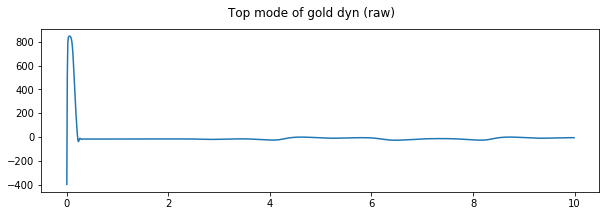

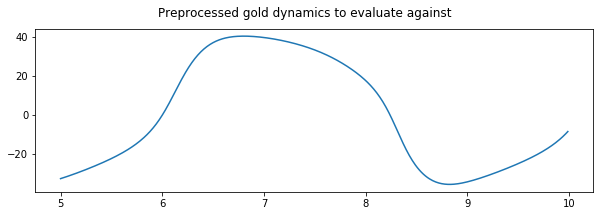

In [2]:
# Initial run
gold_dyn = dynamics.get_jimin_3neuron_dynamics(simul_ts, dt)
top_mode_gold_dyn = dynamics.get_top_mode(gold_dyn)
preprocessed_gold_dyn = distance.preprocess_pop_dyn(gold_dyn, eval_ts)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(simul_timepoints, top_mode_gold_dyn)
fig.suptitle("Top mode of gold dyn (raw)")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(eval_timepoints, preprocessed_gold_dyn)
fig.suptitle("Preprocessed gold dynamics to evaluate against")
_ = _

# Initial unoptimized dynamics

Total runtime = 0.14s
Initial Gg = [[0.         8.31542835 5.36371077]
 [8.31542835 0.         2.57019677]
 [5.36371077 2.57019677 0.        ]]
 Gs = [[0.         2.20887676 8.16130952]
 [7.43860151 0.         3.65310833]
 [7.98837384 7.10204481 0.        ]]

Initial error = 881.0037160523538


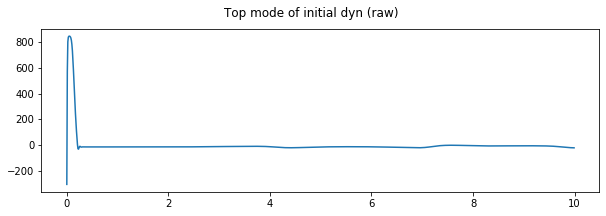

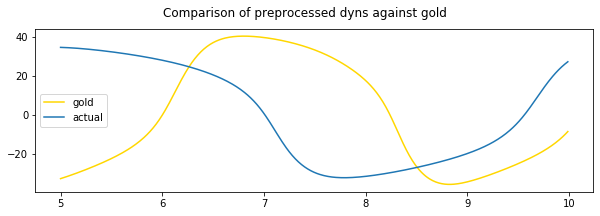

In [3]:
init_Gg, init_Gs, is_inhibitory = connectomes.get_random_connectome(N)
I_ext = dynamics.get_jimin_3neuron_Iext()
initial_dyn = dynamics.run_neural_model(N, init_Gg, init_Gs, is_inhibitory, I_ext, simul_ts, dt)

top_mode_initial_dyn = dynamics.get_top_mode(initial_dyn)
preprocessed_initial_dyn = distance.preprocess_pop_dyn(initial_dyn, eval_ts)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(simul_timepoints, top_mode_initial_dyn)
fig.suptitle("Top mode of initial dyn (raw)")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(eval_timepoints, preprocessed_gold_dyn, label="gold", c="gold")
ax.plot(eval_timepoints, preprocessed_initial_dyn, label="actual")
ax.legend()
fig.suptitle("Comparison of preprocessed dyns against gold")

error = distance.ts_distance_euclidean(preprocessed_gold_dyn, preprocessed_initial_dyn)
print("Initial Gg = %s\n Gs = %s\n" % (init_Gg, init_Gs))
print("Initial error = " + str(error))
_ = _

# Perform optimization

In [35]:
eval_times = []
errors = []
def create_obj_fun(N, preprocessed_gold_dyn, eval_ts):
  num_called = 0
  min_error = 1000000
  def obj_fun(compact_vec):
    nonlocal num_called
    nonlocal min_error
    global init_Gg
    global init_Gs
    global eval_times
    global errors
    num_called += 1
    gg_mat, gs_mat = connectomes.compact_to_model_param(compact_vec, N)
    pop_dyn = dynamics.run_neural_model(N, gg_mat, gs_mat, is_inhibitory, I_ext, simul_ts, dt)
    preprocessed_pop_dyn = distance.preprocess_pop_dyn(pop_dyn, eval_ts)
    error = distance.ts_distance_euclidean(preprocessed_gold_dyn, preprocessed_pop_dyn)
    min_error = min(min_error, error)
    if num_called % 10 == 0:
      print("Evaluation %s, error = %.2f, min_error = %.2f" % (num_called, error, min_error))
      print("Gg = " + str(gg_mat))
      print("Gs = " + str(gs_mat))
      print("delta Gg = " + str((init_Gg - gg_mat).round(2)))
      print("delta Gs = " + str((init_Gs - gs_mat).round(2)))
      eval_times.append(num_called)
      errors.append(error)
    
    return error
  return obj_fun

In [36]:
from scipy.optimize import minimize
from scipy.optimize import basinhopping
import time

init_cond_compact = connectomes.model_to_compact_param(init_Gg, init_Gs, N)
obj_fun = create_obj_fun(N, preprocessed_gold_dyn, eval_ts)
bnds = [(0, 10)] * len(init_cond_compact)

"""
These methods are discarded:
Doesn't handle bounds. Documentation says: L-BFGS-B, TNC, SLSQP and trust-constr 
- BFGS 
- Powell 
- Nelder-Mead
"""

# See the options from here
# https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.optimize.show_options.html
def optimize_with_SLSQP():
  return minimize(obj_fun, init_cond_compact, method='SLSQP', bounds=bnds,
                  options={'maxiter':100})

def optimize_with_L_BFGS_B():
  return minimize(obj_fun, init_cond_compact, method='L-BFGS-B', bounds=bnds,
                  options={'maxiter':10})

def optimize_with_TNC():
  return minimize(obj_fun, init_cond_compact, method='TNC', bounds=bnds,
                  options={'maxiter':10})

def optimize_with_trust_constr():
  return minimize(obj_fun, init_cond_compact, method='trust-constr', bounds=bnds,
                  options={'maxiter':100})

def optimize_with_basin_hopping():
  minimizer_kwargs = {"method":"Powell", "bounds":bnds}
  # You can add niter=k to limit the number of bruteforces
  return basinhopping(obj_fun, init_cond_compact, minimizer_kwargs=minimizer_kwargs)
  
start_time = time.time()
res = optimize_with_trust_constr()
print("Total optimization time = %.2fs" % (time.time() - start_time))
print(res)

Total runtime = 0.11s
Total runtime = 0.09s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Evaluation 10, error = 881.00, min_error = 880.94
Gg = [[0.         8.31542835 5.36371077]
 [8.31542835 0.         2.57019677]
 [5.36371077 2.57019677 0.        ]]
Gs = [[0.         2.20887676 8.16130952]
 [7.43860151 0.         3.65310838]
 [7.98837384 7.10204481 0.        ]]
delta Gg = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
delta Gs = [[ 0.  0.  0.]
 [ 0.  0. -0.]
 [ 0.  0.  0.]]
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.11s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.08s
Evaluation 20, error = 1122.02, min_error = 880.94
Gg = [[0.         8.33498857 5.36609365]
 [8.33498857 0.         2.00890071]
 [5.36609365 2.00890071 0.        ]]
Gs = [[0.   

Total runtime = 0.11s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.10s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Evaluation 140, error = 797.32, min_error = 768.40
Gg = [[0.         8.31762987 5.36414719]
 [8.31762987 0.         2.43039549]
 [5.36414719 2.43039549 0.        ]]
Gs = [[0.         2.20541857 8.16477014]
 [7.39354027 0.         3.6514812 ]
 [7.99197407 7.10453312 0.        ]]
delta Gg = [[ 0.   -0.   -0.  ]
 [-0.    0.    0.14]
 [-0.    0.14  0.  ]]
delta Gs = [[ 0.    0.   -0.  ]
 [ 0.05  0.    0.  ]
 [-0.   -0.    0.  ]]
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.11s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.09s
Evaluation 150, error = 799.01, min_error = 768.40
Gg = [[0.         8.31788574 5.36416899]
 [8.31788574 0.         2.43040036]
 [5.36416899 2.43040036 0

Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.10s
Total runtime = 0.12s
Total runtime = 0.10s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.08s
Evaluation 270, error = 789.95, min_error = 768.40
Gg = [[0.         8.31814165 5.36419124]
 [8.31814165 0.         2.43041362]
 [5.36419124 2.43041362 0.        ]]
Gs = [[0.         2.20553026 8.16477413]
 [7.39353705 0.         3.65152232]
 [7.99198573 7.10453065 0.        ]]
delta Gg = [[ 0.   -0.   -0.  ]
 [-0.    0.    0.14]
 [-0.    0.14  0.  ]]
delta Gs = [[ 0.    0.   -0.  ]
 [ 0.05  0.    0.  ]
 [-0.   -0.    0.  ]]
Total runtime = 0.13s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.10s
Total runtime = 0.12s
Total runtime = 0.11s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Evaluation 280, error = 769.76, min_error = 768.40
Gg = [[0.         8.31814169 5.36419124]
 [8.31814169 0.         2.43041362]
 [5.36419124 2.43041362 0

Total runtime = 0.10s
Total runtime = 0.09s
Total runtime = 0.09s
Total runtime = 0.10s
Total runtime = 0.09s
Total runtime = 0.09s
Total runtime = 0.10s
Total runtime = 0.09s
Total runtime = 0.09s
Evaluation 400, error = 182.07, min_error = 176.59
Gg = [[0.         7.7464071  5.3531213 ]
 [7.7464071  0.         2.39255767]
 [5.3531213  2.39255767 0.        ]]
Gs = [[0.         2.15095167 8.07918447]
 [7.40060687 0.         3.68000367]
 [7.89743582 7.0477848  0.        ]]
delta Gg = [[0.   0.57 0.01]
 [0.57 0.   0.18]
 [0.01 0.18 0.  ]]
delta Gs = [[ 0.    0.06  0.08]
 [ 0.04  0.   -0.03]
 [ 0.09  0.05  0.  ]]
Total runtime = 0.09s
Total runtime = 0.12s
Total runtime = 0.10s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.11s
Total runtime = 0.11s
Evaluation 410, error = 189.80, min_error = 176.59
Gg = [[0.         7.75108576 5.35370692]
 [7.75108576 0.         2.39296096]
 [5.35370692 2.39296096 0.        

Total runtime = 0.09s
Total runtime = 0.11s
Total runtime = 0.10s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Evaluation 530, error = 194.43, min_error = 176.59
Gg = [[0.         7.75576306 5.35435984]
 [7.75576306 0.         2.39322418]
 [5.35435984 2.39322418 0.        ]]
Gs = [[0.         2.1513558  8.08034565]
 [7.40044842 0.         3.6798768 ]
 [7.89871512 7.04857645 0.        ]]
delta Gg = [[0.   0.56 0.01]
 [0.56 0.   0.18]
 [0.01 0.18 0.  ]]
delta Gs = [[ 0.    0.06  0.08]
 [ 0.04  0.   -0.03]
 [ 0.09  0.05  0.  ]]
Total runtime = 0.11s
Total runtime = 0.10s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.09s
Evaluation 540, error = 194.66, min_error = 176.59
Gg = [[0.         7.75576351 5.35436001]
 [7.75576351 0.         2.39322397]
 [5.35436001 2.39322397 0.        ]]
Gs = [[0.         2

Total runtime = 0.09s
Total runtime = 0.09s
Total runtime = 0.11s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.08s
Evaluation 660, error = 201.65, min_error = 176.59
Gg = [[0.         7.75278191 5.36145131]
 [7.75278191 0.         2.39417322]
 [5.36145131 2.39417322 0.        ]]
Gs = [[0.         2.1435073  8.0807289 ]
 [7.39802242 0.         3.69216804]
 [7.89331625 7.05251725 0.        ]]
delta Gg = [[0.   0.56 0.  ]
 [0.56 0.   0.18]
 [0.   0.18 0.  ]]
delta Gs = [[ 0.    0.07  0.08]
 [ 0.04  0.   -0.04]
 [ 0.1   0.05  0.  ]]
Total runtime = 0.08s
Total runtime = 0.10s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.08s
Evaluation 670, error = 194.22, min_error = 176.59
Gg = [[0.         7.75382052 5.3576073 ]
 [7.75382052 0.         2.39343775]
 [5.3576073 

Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.09s
Total runtime = 0.10s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.09s
Evaluation 790, error = 181.63, min_error = 176.59
Gg = [[0.         7.75559027 5.35441793]
 [7.75559027 0.         2.39316103]
 [5.35441793 2.39316103 0.        ]]
Gs = [[0.         2.15129232 8.08033582]
 [7.40029785 0.         3.68000404]
 [7.89863984 7.04864112 0.        ]]
delta Gg = [[0.   0.56 0.01]
 [0.56 0.   0.18]
 [0.01 0.18 0.  ]]
delta Gs = [[ 0.    0.06  0.08]
 [ 0.04  0.   -0.03]
 [ 0.09  0.05  0.  ]]
Total runtime = 0.10s
Total runtime = 0.08s
Total runtime = 0.09s
Total runtime = 0.09s
Total runtime = 0.09s
Total runtime = 0.10s
Total runtime = 0.10s
Total runtime = 0.08s
Total runtime = 0.10s
Total runtime = 0.09s
Evaluation 800, error = 181.33, min_error = 176.59
Gg = [[0.         7.75559183 5.35441788]
 [7.75559183 0.         2.39316237]
 [5.35441788 2.39316237 0.        

Total runtime = 0.10s
Total runtime = 0.09s
Total runtime = 0.09s
Total runtime = 0.10s
Total runtime = 0.11s
Total runtime = 0.11s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Evaluation 920, error = 215.78, min_error = 176.59
Gg = [[0.         7.72779249 5.35248504]
 [7.72779249 0.         2.40227296]
 [5.35248504 2.40227296 0.        ]]
Gs = [[0.         2.15482717 8.08242436]
 [7.40118554 0.         3.68488567]
 [7.89352259 6.99523507 0.        ]]
delta Gg = [[0.   0.59 0.01]
 [0.59 0.   0.17]
 [0.01 0.17 0.  ]]
delta Gs = [[ 0.    0.05  0.08]
 [ 0.04  0.   -0.03]
 [ 0.09  0.11  0.  ]]
Total runtime = 0.09s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.11s
Total runtime = 0.09s
Total runtime = 0.09s
Total runtime = 0.09s
Total runtime = 0.08s
Total runtime = 0.08s
Total runtime = 0.08s
Evaluation 930, error = 187.30, min_error = 176.59
Gg = [[0.         7.70904398 5.34836096]
 [7.70904398 0.         2.40867882]
 [5.34836096 2.40867882 0.        

The optimized Gg and Gs are:
[[0.         7.70904398 5.34836096]
 [7.70904398 0.         2.40867882]
 [5.34836096 2.40867882 0.        ]]
[[0.         2.15894002 8.07671394]
 [7.40151789 0.         3.67358688]
 [7.89650829 6.98792462 0.        ]]

Old Gg and Gs are:
[[0.         8.31542835 5.36371077]
 [8.31542835 0.         2.57019677]
 [5.36371077 2.57019677 0.        ]]
[[0.         2.20887676 8.16130952]
 [7.43860151 0.         3.65310833]
 [7.98837384 7.10204481 0.        ]]

The difference matrices are:
[[ 0.         -0.60638437 -0.01534981]
 [-0.60638437  0.         -0.16151795]
 [-0.01534981 -0.16151795  0.        ]]
[[ 0.         -0.04993674 -0.08459558]
 [-0.03708363  0.          0.02047855]
 [-0.09186555 -0.11412019  0.        ]]



Text(0.5, 0.98, 'Error trends during optimization')

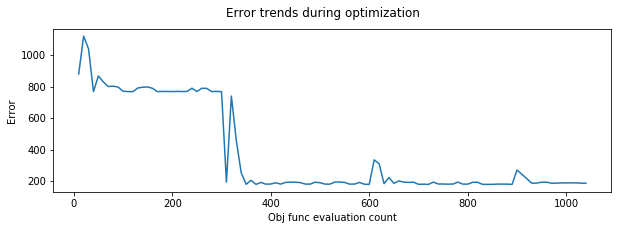

In [39]:
new_Gg, new_Gs = connectomes.compact_to_model_param(res.x, N)
print("The optimized Gg and Gs are:\n%s\n%s\n" % (new_Gg, new_Gs))
print("Old Gg and Gs are:\n%s\n%s\n" % (init_Gg, init_Gs))
print("The difference matrices are:\n%s\n%s\n" % (new_Gg-init_Gg, new_Gs-init_Gs))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(eval_times, errors)
ax.set_xlabel('Obj func evaluation count')
ax.set_ylabel('Error')
fig.suptitle("Error trends during optimization")


# Compare optimized dynamics against golden

Total runtime = 0.12s
Optimized error = 187.29943302611505


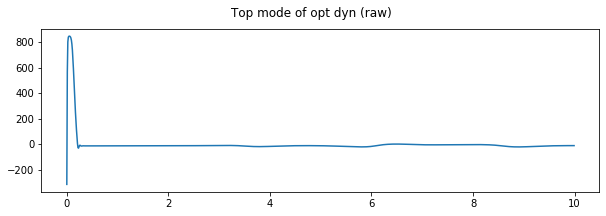

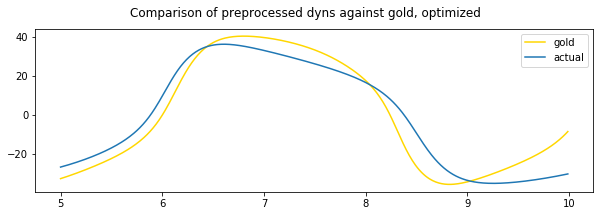

In [40]:
# Plot the optimized results

opt_dyn = dynamics.run_neural_model(N, new_Gg, new_Gs, is_inhibitory, I_ext, simul_ts, dt)

top_mode_opt_dyn = dynamics.get_top_mode(opt_dyn)
preprocessed_opt_dyn = distance.preprocess_pop_dyn(opt_dyn, eval_ts)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(simul_timepoints, top_mode_opt_dyn)
fig.suptitle("Top mode of opt dyn (raw)")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(eval_timepoints, preprocessed_gold_dyn, label="gold", c="gold")
ax.plot(eval_timepoints, preprocessed_opt_dyn, label="actual")
ax.legend()
fig.suptitle("Comparison of preprocessed dyns against gold, optimized")

error = distance.ts_distance_euclidean(preprocessed_gold_dyn, preprocessed_opt_dyn)
print("Optimized error = " + str(error))
_ = _